In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup as bs
import pandas as pd
import re
import time
from tqdm import tqdm

### 댓글 가져오기
- selenium.webdriver를 이용한 chromedriver드라이버 실행
- URL 정의 및 chrom 브라우저를 이용한 접속 및 정보 가져오기
- 스크롤바 이동 및 [더보기] 버튼 클릭

In [3]:
url='https://play.google.com/store/apps/details?id=com.coupang.mobile&showAllReviews=true'
driver = webdriver.Chrome('c:/pydata/chromedriver.exe')
time.sleep(2)
driver.get(url)
time.sleep(2)
keys=Keys()

for i in tqdm(range(20)):
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);") 
    time.sleep(2)
    try:
        driver.find_element_by_css_selector("#fcxH9b > div.WpDbMd > c-wiz > div > div.ZfcPIb > div > div > main > div > div.W4P4ne > div:nth-child(2) > div.PFAhAf > div > span > span").click()
        time.sleep(2)
    except:
        pass


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:53<00:00,  2.67s/it]


### 댓글 가져오기
- chrom 드라이브의 소스정보 가져오기
- 원하는 html 코드 찾아 텍스트 가져오기
- 가져온 데이터에서 정규화 표현(re)를 이용해 불필요한 기호 등 제거하기
- 딕셔너리 구조로 저장 후 DataFrame으로 변경하기
- DataFrame으로 변경된 데이터 저장하기

In [6]:
html_source=driver.page_source
soup=bs(html_source, "html.parser")

div_soup=soup.select("div.d15Mdf.bAhLNe")
review_lst=[]
for div in tqdm(div_soup):
    redate=div.find("span", class_="p2TkOb").text
    review=div.select("div.UD7Dzf > span")[0].text
    review=re.sub("[^ㄱ-ㅣ가-힣a-zA-Z0-9 ]","", review)
    review_lst.append({"date":redate, "review":review})

df1=pd.DataFrame(review_lst)
df1.to_csv("c:/pydata/쿠팡_리뷰.csv", encoding="cp949")

100%|████████████████████████████████████████████████████████████████████████████| 1080/1080 [00:00<00:00, 7219.48it/s]


### TextBlob 모듈을 이용한 문장 학습 후 긍부정 나누기
- 리뷰 데이터에서 일부를 추출해 긍부정 학습 데이터 만들기
- 만들어진 학습 데이터를 가져와 NaiveBayesClassifier에 사용하기 위한 학습용 리트스 데이터 생성하기
- 학습된 결과를 확인하기 위한 테스트 자료 만들기

In [7]:
from textblob import TextBlob as tb
from textblob.classifiers import NaiveBayesClassifier

df2=pd.read_csv("c:/pydata/쿠팡_리뷰_학습.csv", encoding="cp949")

train=[]
for i in df2.index:
    train.append((df2.loc[i, "review"], df2.loc[i, "posneg"]))
    
test = [('쿠팡 삭제할게요 잘먹고 잘사세요', '부정'),
        ('배송도 빠르고 좋아용 멤버스가입 했더니 일욜에 시켜서 월욜에 받은적도 있음', '긍정'),
        ('배송도 빨리오고 상품 쉽게 찾을수 있어서 좋네요.', '긍정'),
        ('기사님이 너무자주 오배송하시네요 다른집으로 배송이 되고안온걸 왔다고 하고', '부정'),
        ('편리하고 배송도 빠른고', '긍정'),
        ('탈퇴하려 다시 설치한다 폭망해라 살인마 수전노 개쿠팡', '부정')]

- 학습용 데이터를 이용해 NaiveBayesClassifier에 학습시키기
- 학습된 결과 테스트 자료를 이용해 정확도 확인하기

In [8]:
pos_neg=NaiveBayesClassifier(train)
test_acc=pos_neg.accuracy(test)
print(f'정확도: {test_acc}')

정확도: 1.0


- 학습된 결과는 이용해 df1에 저장된 리뷰 정보에 대하여 긍부정 확인하기
- 긍부정 확인 결과 리스트로 만들어 df1 데이터에 열 추가하기

In [9]:
pos_neg_txt=[]
for i in df1.index:
    pos_neg_txt.append(pos_neg.classify(df1.loc[i, 'review']))
    
df1['posneg']=pos_neg_txt
df1.head()

,date,review,posneg
0,2021년 7월 26일,별 하나도 아까울정도로 서비스 개판임 다들 로켓배송 칭찬하는데 로켓배송 상품이 다음...,부정
1,2021년 7월 25일,공룡 덩치라 그렇지만서도 로켓배송 아묻따 반품 넓은 선택폭 최저가 아무도 못이죠 그...,부정
2,2021년 7월 5일,good 이었지만 대표 경영진의 모습들이 쿠팡이라는 기업 이미지를 한참 밑바닥으로 ...,부정
3,2021년 7월 25일,배송이나 상품 서비스를 볼 때마다 생각남 오늘은 몇명이 갈려나가서 우리가 편리할까 ...,긍정
4,2021년 7월 24일,로켓배송 완전 편하고 배송비도 엄청나게 아낄 수 있음 그리고 무엇보다 고객센터가 잘...,긍정


### 데이터 시각화
- df1에서 리뷰에 대한 긍부정 내용을 이용한 groupby 진행하기
- 결과를 이용해 긍부정 차트 작성하기

,date,review
posneg,,
긍정,647,647
부정,433,433


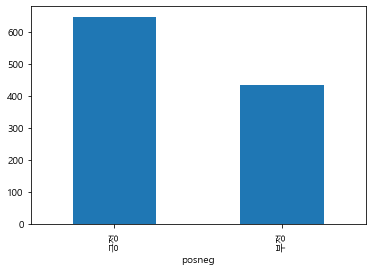

In [10]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
font_family = font_manager.FontProperties(fname='C:/Windows/Fonts/malgunsl.ttf').get_name()
plt.rc('font', family=font_family)

posneg_df=df1.groupby("posneg")[["date", "review"]].count()
posneg_df['date'].plot.bar()
posneg_df

### KNU 사전을 이용한 긍부정 분류

- 입력 워드에 대해 SentiWord 사전을 이용해 긍부정 판단하는 함수 작업하기

In [11]:
def pos_neg(word):
    tmp=SentiWord[(SentiWord['word']==word) | (SentiWord['word_root']==word)]
    try:
        word_res=(word, tmp['polarity'][tmp.index[0]])
    except:
        word_res=(word, 0)
        
    return word_res

- KNU 사전을 이용에 미리 만들어 놓은 사용자 SentiWord 읽어오기
- 필요시 해당 사전에 새로운 긍부정 내용 추가하기(상황에 따라 다시 저장)
- df1에서 리뷰 데이터 전체 하나로 만들기

In [12]:
SentiWord=pd.read_csv('c:/pydata/sw/SentiWord_info.csv')
#SentiWord.loc[len(SentiWord)]=["징용", "징용", -2]
txt=""
for i in df1.index:
    txt=txt+" "+str(df1['review'].loc[i])

- 생선된 리뷰 데이터 전체를 konlpy의 Okt 클래스를 이용해 형태소별 분류
- (참고: nouns : 명사 추출 / morphs : 형태소 추출 / pos : 품사 부착)
- 분류된 토픽(단어)를 이용해 긍정/부정/기타로 분류하기

In [13]:
from konlpy.tag import Okt
okt=Okt()
morp=okt.morphs(txt)

pos_list=[]
neg_list=[]
unkwon_list=[]
for noun in tqdm(morp, "긍/부정 나누기"):
    word_res=pos_neg(noun)
    if word_res[1] > 0:
        pos_list.append(word_res[0])
    elif word_res[1] < 0:
        neg_list.append(word_res[0])
    else:
        unkwon_list.append(word_res[0])

긍/부정 나누기: 100%|███████████████████████████████████████████████████████████| 28356/28356 [00:47<00:00, 593.94it/s]


- 결과 출력하기

In [14]:
print("긍정키워드 수:", len(pos_list), "개")
print("부정키워드 수:", len(neg_list), "개")
print("중립 또는 모름 키워드 수:", len(unkwon_list), "개")

긍정키워드 수: 1284 개
부정키워드 수: 3094 개
중립 또는 모름 키워드 수: 23978 개


### 데이터 시각화
- nltk의 Text를 이용한 긍정/부정 단어 시각화

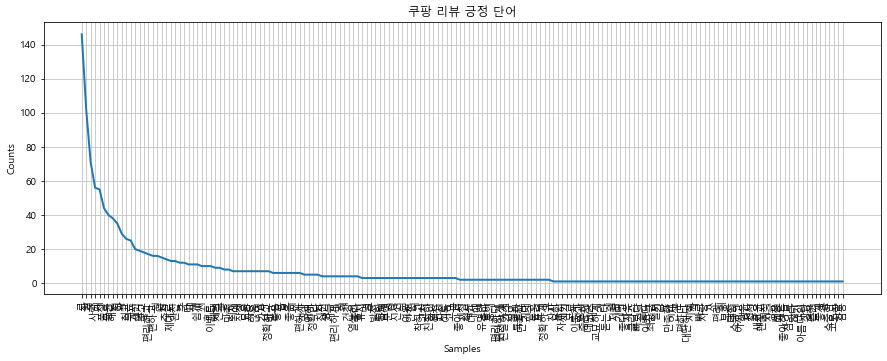

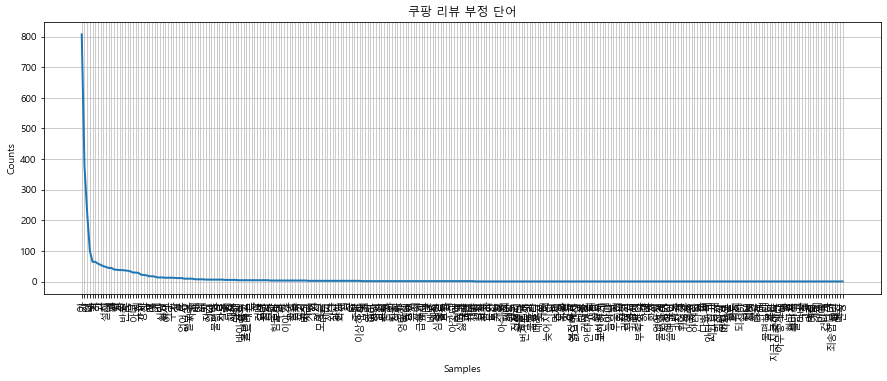

In [28]:
from nltk import Text
pos_txt=Text(pos_list)
neg_txt=Text(neg_list)

plt.figure(figsize=(15,5))
plt.title('쿠팡 리뷰 긍정 단어')
pos_txt.plot()
plt.show()

plt.figure(figsize=(15,5))
plt.title('쿠팡 리뷰 부정 단어')
neg_txt.plot()
plt.show()

- 주요 단어의 위치 확인하기

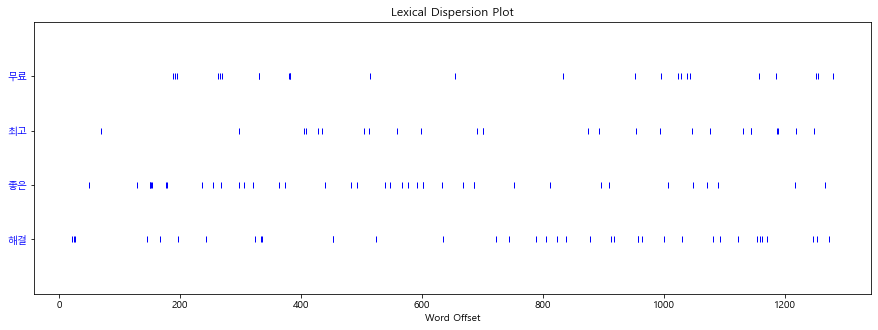

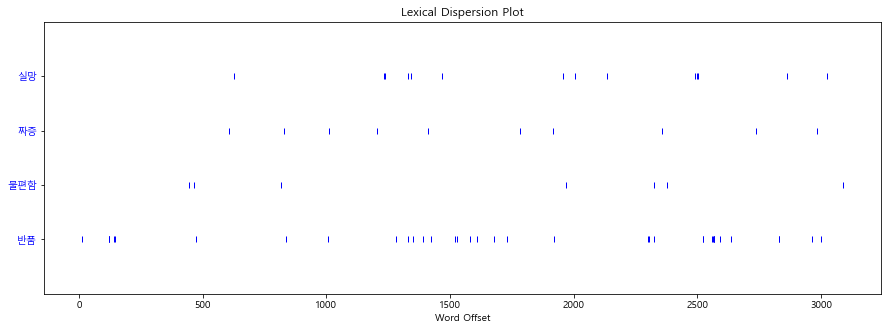

In [30]:
plt.figure(figsize=(15,5))
pos_txt.dispersion_plot(['무료', "최고", '좋은', '해결'])
plt.show()

plt.figure(figsize=(15,5))
neg_txt.dispersion_plot(['실망', "짜증", '불편함', '반품'])
plt.show()

- Counter를 이용한 단어 빈도수 체크

In [39]:
from collections import Counter   

pos_count=dict(Counter(pos_list).most_common()) # 단어별 갯수 계산 및 내림차순 정렬, dict()로 변경
neg_count=dict(Counter(neg_list).most_common())
unkwon_count=dict(Counter(unkwon_list).most_common())
#print(pos_count)
#print(neg_count)

#### for문과 사용자 stop_word를 이용한 불필요한 단어 제거
- 긍정어 불용어 처리

In [40]:
stop_words="로 것 와 당 명 위 신 사람 하기 뜻 점 순 타 보 히 세 개 열"
stop_words=stop_words.split(" ")

tmp_dic={}
for key, value in pos_count.items():
    if key not in stop_words:
        tmp_dic[key]=value
        
pos_count=tmp_dic
#pos_count

- 부정어 불용어 처리

In [41]:
tmp_dic={}
for key, value in neg_count.items():
    if key not in stop_words:
        tmp_dic[key]=value
        
neg_count=tmp_dic
#neg_count

- 긍정 리뷰를 이용한 워드 클라우드 작성

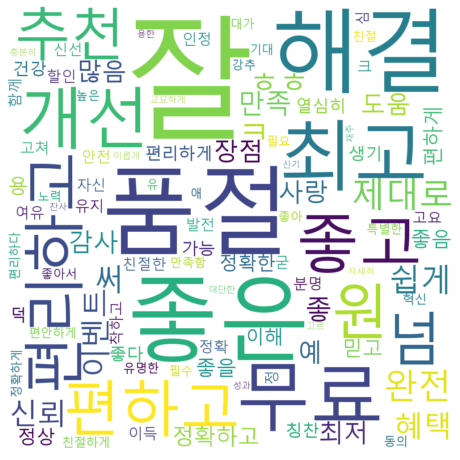

In [42]:
from wordcloud import WordCloud

wordcloud = WordCloud(font_path="c:/Windows/Fonts/malgun.ttf",
                      background_color="white", width=1000, height=1000,
                      max_words=100, max_font_size=300)

wc = wordcloud.generate_from_frequencies(pos_count)
plt.figure(figsize=(8,15))
plt.imshow(wc)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

- 부정 리뷰를 이용한 워드클리우드 작성

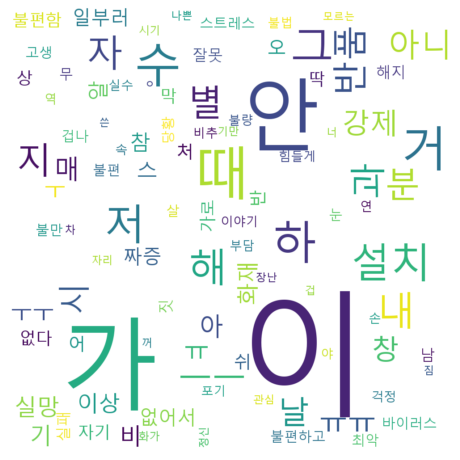

In [43]:
wordcloud = WordCloud(font_path="c:/Windows/Fonts/malgun.ttf",
                      background_color="white", width=1000, height=1000,
                      max_words=100, max_font_size=300)

wc = wordcloud.generate_from_frequencies(neg_count)
plt.figure(figsize=(8,15))
plt.imshow(wc)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

- 긍단어 DataFrame로 변경 후 빈도수가 10 이상인 데이터 가져와 시각화 하기

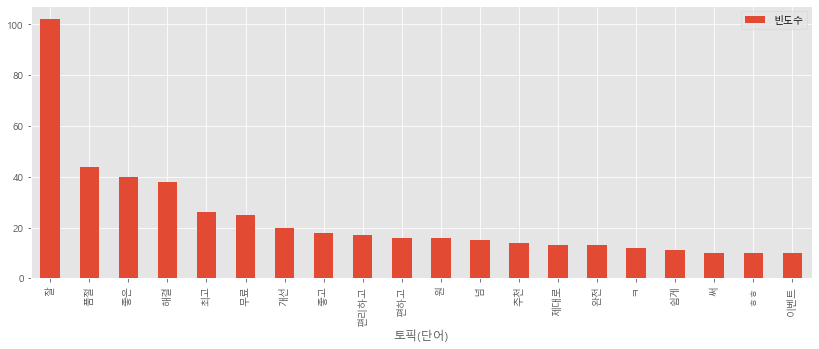

In [51]:
most_pos=[]
for key, value in pos_count.items():
    most_pos.append((key, value))

most_df=pd.DataFrame(most_pos, columns=["토픽(단어)", "빈도수"])
plt_pos=most_df[most_df['빈도수']>=10]

plt.style.use('ggplot') 
plt_pos.set_index("토픽(단어)", inplace=True)
plt_pos.plot.bar(figsize=(14, 5))
plt.show()

- 부단어 DataFrame로 변경 후 빈도수가 10 이상인 데이터 가져와 시각화 하기

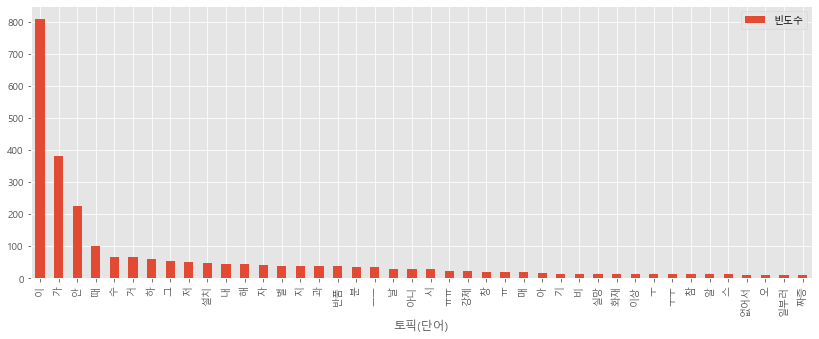

In [52]:
most_neg=[]
for key, value in neg_count.items():
    most_neg.append((key, value))

most_df=pd.DataFrame(most_neg, columns=["토픽(단어)", "빈도수"])
plt_neg=most_df[most_df['빈도수']>=10]

plt.style.use('ggplot') 
plt_neg.set_index("토픽(단어)", inplace=True)
plt_neg.plot.bar(figsize=(14, 5))
plt.show()